# 03:  Sampling Random Numbers

In [267]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
try: plt.style.use('./mc_notebook.mplstyle')
except: pass

## What is a random number?

- There is really no such thing, definitely not on a deterministic classical computer
- Loose term applied to a sequence of independent numbers drawn randomly from some distribution
- Typically we select integers or real values on some finite domain

We have already used the `python` random number generator that lives in `np.random` to sample uniform random numbers $x \in \mathcal{U}_{[0,1)}$ 

In [268]:
np.random.rand()

0.900774052260642

## Sampling Continous Distributions

We can use uniform random numbers to sample any continuous probability distribution by studying cumulative distribution functions:

\begin{equation}
\Pi(x) = \int\limits_{-\infty}^{x} \pi(x') dx' .
\end{equation}

Our starting point will be the uniform distribution which satisfies:

\begin{equation}
\pi_\mathcal{U}(x) = 
\begin{cases}
1 & ; & 0 \le x \le 1 \\
0 & ; & \text{otherwise} 
\end{cases}
\end{equation}

such that:

\begin{equation}
\int_{-\infty}^{\infty} \pi_{\mathcal{U}}(x) dx = 1.
\end{equation}

Now, suppose want to sample some new random variables $y$ from some probability distribution $\pi(y)$.  This requires we identify a mapping $x\leftrightarrow y$ such that probability is conserved, i.e.

\begin{equation}
\pi(y) dy = \pi_{\mathcal{U}}(x) dx \Rightarrow \pi(y) = \frac{dx}{dy}  \pi_{\mathcal{U}}(x) .
\end{equation}

Integrating both sides:

\begin{equation}
\Pi(y) = \int_{-\infty}^y \pi(y') dy' = \int_{-\infty}^{y} \frac{dx}{dy'}  \pi_{\mathcal{U}}(x) dy' = \int_0^y \frac{dx}{dy'} dy' = x(y)
\end{equation}

Therefore, we can invert the CDF $\Pi(y)$ to get $y = \Pi^{-1}(x)$ for a uniformly distributed $x$.

Let's see how this works:

### Example 1
Generate a uniform random number $y$ on the domain $[a,b)$.

We have: 
\begin{equation}
\pi(y) =
\begin{cases}
\frac{1}{b-a} & ; & a \le y \le b \\
0 & ; & \text{otherwise} 
\end{cases}
\end{equation}

So

\begin{equation}
x(y) =\int_a^y \pi(y') dy' = \int_a^y \frac{dy'}{b-a} = \left.\frac{y'}{b-a} \right \rvert_a^y = \frac{y-a}{b-a}
\end{equation}

so $y = (b-a)x + a$,  which is a result we have already used in sampling:

In [269]:
δ = 0.3
np.random.uniform(-δ,δ)

-0.01974203842554423

### Example 2
Consider sampling from the exponential distribution for $y\ge 0$:

\begin{equation}
\pi(y) = \lambda \mathrm{e}^{-\lambda y}.
\end{equation}

As before:

\begin{equation}
x(y) =\int_0^y \pi(y') dy' = \lambda \int_0^y \mathrm{e}^{-\lambda y'}dy' = \left.-\mathrm{e}^{-\lambda y'} \right \rvert_0^y = 1 - \mathrm{e}^{-\lambda y} .
\end{equation}

Solving for $x$:

\begin{align*}
\mathrm{e}^{-\lambda y} &= 1-x \newline
-\lambda y &= \ln (1-x) \newline
y &= -\frac{1}{\lambda} \ln (1-x) 
\end{align*}

which gives $y \in [0,\infty)$ for $x \in [0,1)$.

<br />
<div class="span alert alert-danger">
Note: we need to be careful with our uniform random number $x$ as it can formally take on the end point value $x=1$. 
</div>

### Sampling the exponential distribution

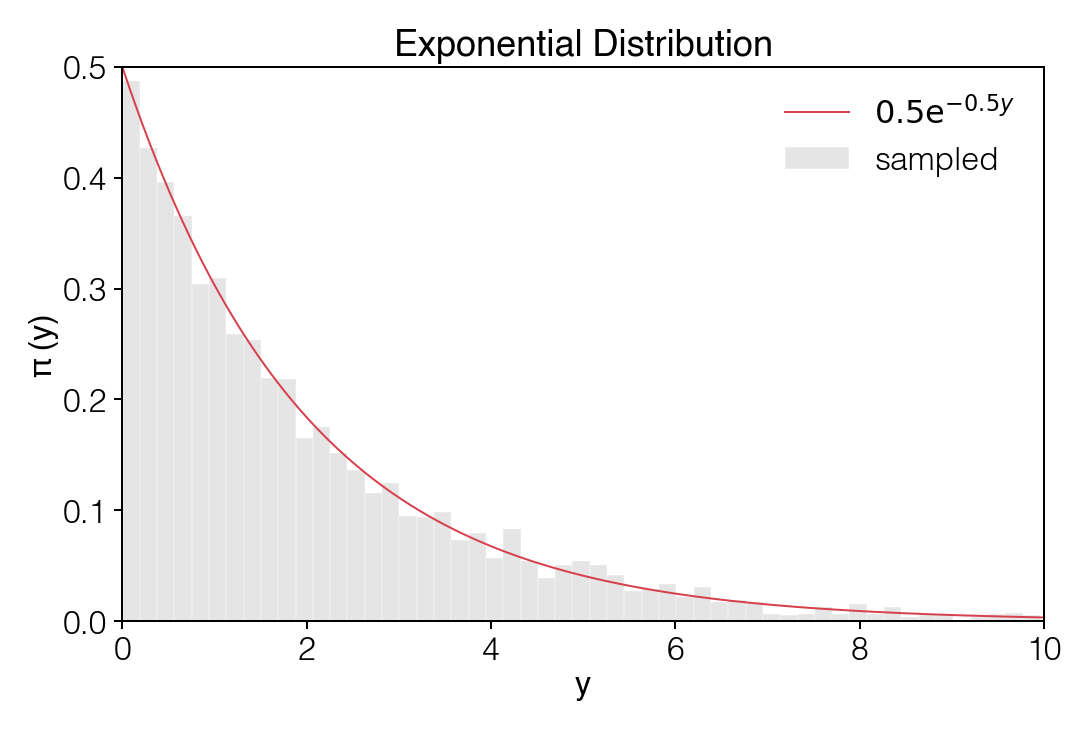

In [270]:
def π_exp(y,λ):
    return λ*np.exp(-λ*y)

N = 2**12
λ = 0.5
y = np.linspace(0,100,N)
plt.plot(y,π_exp(y,λ), label=r'$%3.1f\mathrm{e}^{-%3.1fy}$'%(λ,λ))

# sample y from a uniform x
x = np.random.random(N)
sampled_y = -(1/λ)*np.log(1.0-x)

plt.hist(sampled_y, bins=100, normed=True, ec='w', label='sampled', fc='gray', alpha=0.2);
plt.xlim(0,10);
plt.xlabel('y')
plt.ylabel('π (y)')
plt.title('Exponential Distribution')
plt.legend(loc='upper right')

## Rejection Sampling

What do we do if we can't invert the cumulative distribution function and we are out of tricks?  The technique, known as **von Neumann rejection** is similar to how we computed $\pi$ by throwing stones into a pond.  

Consider some probability distribution function $\pi(x)$ whose cumulative distribution function $\Pi(x)$ cannot be inverted.  Suppose we want to sample this function over the finite range $[x_{\rm min},x_{\rm max})$ where $\pi_{\rm max}$ is the maximal value of $\pi(x)$ on this interval.  Then we can:

1. Generate a sequence of $N$ uniformly distributed random numbers $x_i \in \mathcal{U}_{[x_{\rm min},x_{\rm max})}$
2. Generate a second sequence of $N$ uniformly distribted random numbers $\chi_i \in \mathcal{U}_{[0,\pi_{\rm max})}$
3. Keep only those elements in the first sequence $x_i$ that have $\chi_i < \pi(x_i)$

The resulting set of $x_j$ values will be distributed according to $\pi(x)$.   This works by throwing away unlikely results.

<br />
<div class="span alert alert-warning">
Note: Our probability distribution must be bounded and have a finite range. 
</div>

### Let's return to the task of importance sampling our integral: 

\begin{equation}
I = \frac{\pi\, \mathrm{erf}(5)^2}{100}\int\limits_{-5}^{5} dx \int\limits_{-5}^{5} dx \, \sqrt{1+x^2+y^2}\, \pi(x,y)
\end{equation}

where we want to sample random numbers from:

\begin{equation}
\pi(x,y) =  \frac{\mathrm{e}^{-x^2-y^2}}{\pi\, \mathrm{erf}(5)^2}
\end{equation}

In [271]:
from numpy import pi as π
import scipy.special
def π_import_samp(x,y,L):
    return np.exp(-x**2 - y**2)/(π*scipy.special.erf(L/2)**2)

#### Generate the lists of random numbers:

In [285]:
L = 10
N = 2**16
x = np.random.uniform(-L/2,L/2,N)
y = np.random.uniform(-L/2,L/2,N)
χ = np.random.uniform(0,π_import_samp(0,0,L),N)

#### Perform the rejection

In [286]:
accepted_x = x[χ < π_import_samp(x,y,L)]
accepted_y = y[χ < π_import_samp(x,y,L)]

#### Investigate the Process

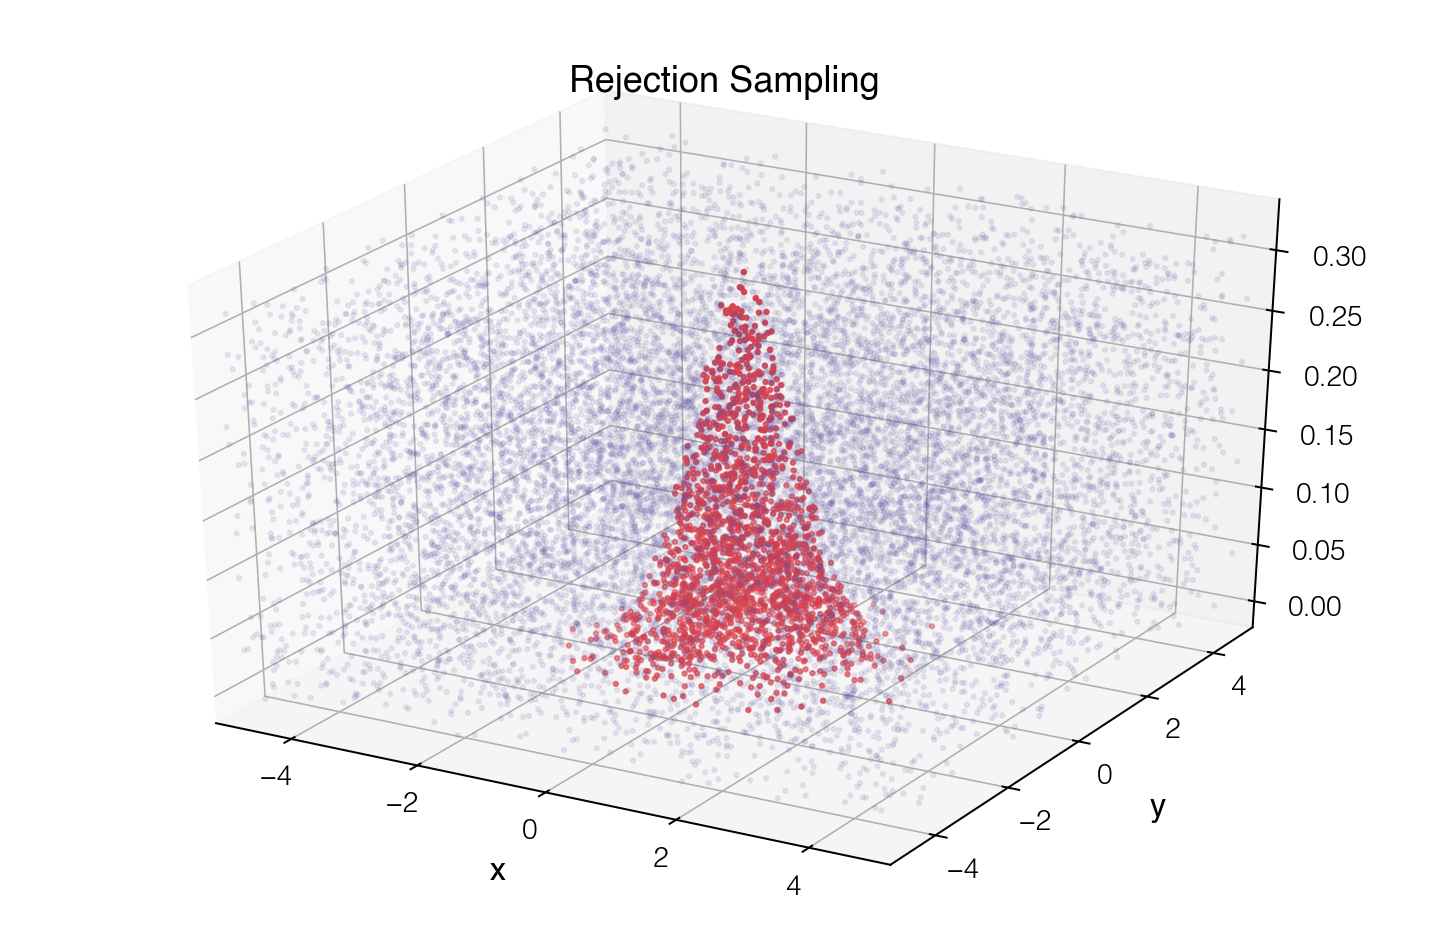

In [281]:
accepted_χ = χ[χ < π_import_samp(x,y,L)]

rejected_x = x[χ >= π_import_samp(x,y,L)]
rejected_y = y[χ >= π_import_samp(x,y,L)]
rejected_χ = χ[χ >= π_import_samp(x,y,L)]

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')

ax.scatter(accepted_x, accepted_y, accepted_χ, c='#D7414E', marker='.')
ax.scatter(rejected_x[::5], rejected_y[::5], rejected_χ[::5], c='#5E4Fa2', marker='.', alpha=0.1)


ax.set_xlabel('x',labelpad=14)
ax.set_ylabel('y',labelpad=14)
ax.set_title('Rejection Sampling')
ax.tick_params(axis='z', which='major', pad=10)


[t.label.set_fontsize(14) for caxis in [ax.xaxis, ax.yaxis, ax.zaxis] for t in caxis.get_major_ticks()];

#### Test the result by building a histogram

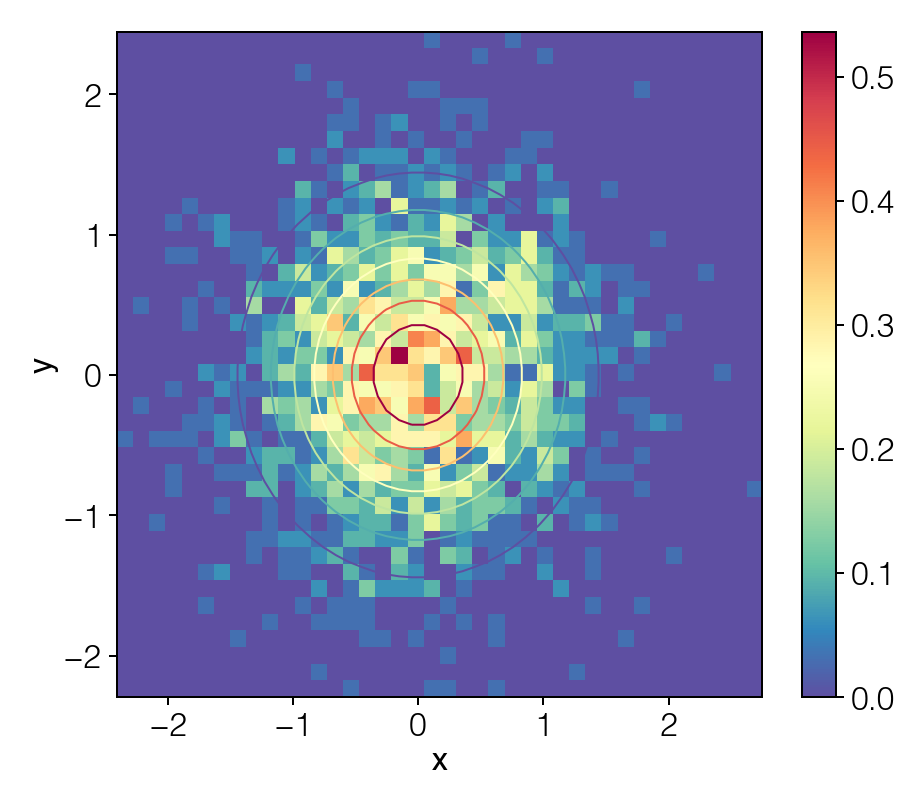

In [277]:
fig = plt.figure(figsize=(7,6))

plt.hist2d(accepted_x, accepted_y, bins=40, normed=True, cmap='Spectral_r')
plt.colorbar()

X, Y = np.meshgrid(np.linspace(-L/2, L/2, 100), np.linspace(-L/2, L/2, 100))
plt.contour(X,Y,π_import_samp(X,Y,L),cmap='Spectral_r');

plt.xlabel('x');
plt.ylabel('y');

## Perform the Importance Sampling

Now we can use these random numbers to compute our integral:

\begin{equation}
I \simeq \frac{\pi\, \mathrm{erf}(5)^2}{100} \frac{1}{N} \sum_n \sqrt{1+x_n^2+y_n^2}
\end{equation}

In [287]:
N = len(accepted_x)
f_import_samp = np.zeros(N)

for n in range(N):
    f_import_samp[n] = np.sqrt(1+accepted_x[n]**2+accepted_y[n]**2)

f_import_samp *= π*scipy.special.erf(L/2)**2/100

I_import_samp = np.average(f_import_samp)
ΔI_import_samp = np.std(f_import_samp)/np.sqrt(N)
δ_import_samp = np.abs(I_import_samp - 0.04332055352082126)/ΔI_import_samp
print('I = %12.10f ± %8.6f' % (I_import_samp,ΔI_import_samp))
print('|I-I_exact|/ΔI = %4.2fσ' % (δ_import_samp))
print('Likelihood     = %5.2f '% (1-scipy.special.erf(δ_import_samp/np.sqrt(2))))

I = 0.0430725154 ± 0.000216
|I-I_exact|/ΔI = 1.15σ
Likelihood     =  0.25 


#### Check out how few random samples were required to get this small error

In [283]:
print('N = %d'% N)

N = 2079
